In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from copy import deepcopy
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D, concatenate, UpSampling2D

### Load data
link: https://www.kaggle.com/datasets/hashbanger/ph2-resized

- trainx: 200 imagens de lesões (192, 256, 3) rgb
- trainy: 200 máscaras dessas imagens (192, 256, 1) grayscale

In [2]:
# Importando as imagens e suas respectivas máscaras do meu Drive
images_dir = Path("/content/drive/MyDrive/UFOP/PDI/archive/ph2_resized/trainx")
masks_dir = Path("/content/drive/MyDrive/UFOP/PDI/archive/ph2_resized/trainy")

In [3]:
# Faz um sort dos arquivos pelo nome, para garantir a ordenação entre as listas de imagens e máscaras
images = sorted(list(map(str, list(images_dir.glob("*.bmp")))))
masks = sorted(list(map(str, list(masks_dir.glob("*.bmp")))))

In [4]:
# Coloca em NumPy
X = np.array([np.array(Image.open(fname)) for fname in images])
Y = np.array([np.array(Image.open(fname)) for fname in masks])

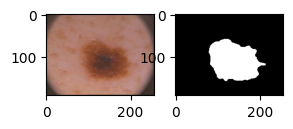

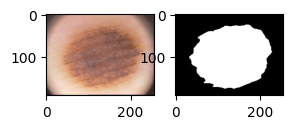

In [5]:
# Exibindo exemplos de lesão e sua respectivas máscaras-resposta
plt.subplot(1,4,1)
plt.imshow(X[77])
plt.subplot(1,4,2)
plt.imshow(Y[77], plt.cm.binary_r)
plt.show()

plt.subplot(1,4,3)
plt.imshow(X[30])
plt.subplot(1,4,4)
plt.imshow(Y[30], plt.cm.binary_r)
plt.show()

### Preprocessing
- dividir os dados entre treino e teste
- aumentar os dados com rotation, horizontal flip, vertical flip (200 -> 5600

- dividir os dados de treino entre treino e validação

In [6]:
# Split em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
print(len(x_train))
print(len(x_test))

160
40


In [8]:
def random_rotation(x_image, y_image):
    rows_x, cols_x, _ = x_image.shape
    rows_y, cols_y = y_image.shape

    random_angle = np.random.randint(-40,40)

    # cv2.getRotationMatrix2D(center, angle, scale)
    rotation_matrix_x = cv2.getRotationMatrix2D((cols_x/2, rows_x/2), random_angle, 1)
    rotation_matrix_y = cv2.getRotationMatrix2D((cols_y/2, rows_y/2), random_angle, 1)

    # warpAffine(inputImage, transformationMatrix, outputImageSize )
    x_image = cv2.warpAffine(x_image, rotation_matrix_x, (cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'), rotation_matrix_y, (cols_y,rows_y))

    return x_image, y_image.astype('int')


def gen_flip(x_image, y_image, flag):
    x_image = cv2.flip(x_image, flag)
    y_image = cv2.flip(y_image.astype('float32'), flag)
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    return gen_flip(x_image, y_image, 1)

def vertical_flip(x_image, y_image):
    return gen_flip(x_image, y_image, 0)

def img_augmentation(x, y, cycles):
    x_temp = deepcopy(x)
    y_temp = deepcopy(y)

    x_rotated_images = []
    y_rotated_images = []
    x_flipped_horizontally_images = []
    y_flipped_horizontally_images = []
    x_flipped_vertically_images = []
    y_flipped_vertically_images = []

    for cycle in range(cycles):
        for idx in range(len(x_temp)):
            x,y = random_rotation(x_temp[idx], y_temp[idx])
            x_rotated_images.append(x)
            y_rotated_images.append(y)

            x,y = horizontal_flip(x_temp[idx], y_temp[idx])
            x_flipped_horizontally_images.append(x)
            y_flipped_horizontally_images.append(y)

            x,y = vertical_flip(x_temp[idx], y_temp[idx])
            x_flipped_vertically_images.append(x)
            y_flipped_vertically_images.append(y)

        x_augmented_images = np.concatenate([x_rotated_images, x_flipped_horizontally_images, x_flipped_vertically_images])
        y_augmented_images = np.concatenate([y_rotated_images, y_flipped_horizontally_images, y_flipped_vertically_images])

    return x_augmented_images, y_augmented_images

In [9]:
# aumentar os sets de treino e de teste
x_train_augmented_images, y_train_augmented_images = img_augmentation(x_train, y_train, 3)

x_train_full = np.concatenate([x_train, x_train_augmented_images])
y_train_full = np.concatenate([y_train, y_train_augmented_images])

x_test_augmented_images, y_test_augmented_images = img_augmentation(x_test, y_test, 3)

x_test_full = np.concatenate([x_test, x_test_augmented_images])
y_test_full = np.concatenate([y_test, y_test_augmented_images])

In [10]:
print(len(x_train_full))
print(len(x_test_full))

1600
400


In [11]:
# dividindo treino entre treino e validação
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.20)


In [12]:
print(len(x_train))
print(len(x_val))

1280
320


In [13]:
# Compara a sobreposição das áreas marcadas como verdadeiras nas máscaras y_true e y_pred.
# A interseção dessas áreas é dividida pela união, Evitando divisão por zero
# Quanto menor a distância de Jaccard, maior a similaridade entre as áreas segmentadas nas máscaras
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)


# Índice de Jaccard (IoU) entre duas máscaras binárias.
# É uma métrica mais intuitiva, onde valores mais altos indicam melhor qualidade de segmentação
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


# Valores mais altos (1) indicam uma melhor concordância entre as áreas segmentadas nas máscaras,
# Também tem smooth
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# Calcula a proporção de verdadeiros positivos (TP) em relação ao total de itens previstos como positivos pelo modelo
# (TP + falsos positivos)
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Calcula a proporção de verdadeiros positivos (TP) em relação ao total de itens que são realmente positivos
# (TP + falsos negativos)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [14]:
# MODELO SEGNET
# ConvUnit: Uma unidade convolucional
# ConvBlock: empilha várias unidades convolucionais em sequência, seguido por uma camada de MaxPooling
# bloco de convolução e transposição que inclui uma camada de UpSampling + unidades convolucionais transpostas

class ConvUnit(layers.Layer):
    def __init__(self, filters, kernel_size, activation, transpose=False, **kwargs):
        super().__init__(**kwargs)

        if transpose:
            self.conv = layers.Conv2DTranspose(filters, kernel_size, padding='same')
        else:
            self.conv = layers.Conv2D(filters, kernel_size, padding='same')

        self.bn = layers.BatchNormalization()
        self.activation = layers.Activation(activation)
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activation(x)
        return x

class ConvBlock(layers.Layer):
    def __init__(self, num_conv_unit, filters, kernel_size, activation, **kwargs):
        super().__init__(**kwargs)
        self.conv_units = [ConvUnit(filters, kernel_size, activation) for _ in range(num_conv_unit)]
        self.pool = layers.MaxPool2D()

    def call(self, inputs):
        x = inputs
        for conv_unit in self.conv_units:
            x = conv_unit(x)
        x = self.pool(x)
        return x

class UpSamplingConvTBlock(layers.Layer):
    def __init__(self, num_conv_unit, filters, kernel_size, activation, **kwargs):
        super().__init__(**kwargs)
        self.up_sampling = layers.UpSampling2D()
        self.conv_units = [ConvUnit(filters, kernel_size, activation, transpose=True) for _ in range(num_conv_unit)]

    def call(self, inputs):
        x = inputs
        x = self.up_sampling(x)
        for conv_unit in self.conv_units:
            x = conv_unit(x)
        return x

In [15]:
# O MODELO
# ENCODER: Reduzir as dimensões espaciais da imagem e aumentar as representações de recursos
# BOTTLENECK: (fully connected) com ativação ReLU para reduzir ainda mais a dimensionalidade das características
# DECODER: aumentam as dimensões espaciais da imagem. recuperar detalhes e informações espaciais perdidas durante a codificação.
def SegNet(activation="relu"):
    inputs = keras.Input(shape=(192, 256, 3))

    # encoder
    x = ConvBlock(num_conv_unit=2,
                  filters=64,
                  kernel_size=(3,3),
                  activation=activation)(inputs)

    x = ConvBlock(num_conv_unit=2,
                  filters=128,
                  kernel_size=(3,3),
                  activation=activation)(x)

    x = ConvBlock(num_conv_unit=3,
                  filters=256,
                  kernel_size=(3,3),
                  activation=activation)(x)

    x = ConvBlock(num_conv_unit=3,
                  filters=512,
                  kernel_size=(3,3),
                  activation=activation)(x)

    x = ConvBlock(num_conv_unit=3,
                  filters=512,
                  kernel_size=(3,3),
                  activation=activation)(x)

    # bottleneck
    x = layers.Dense(1024, activation=activation)(x)
    x = layers.Dense(1024, activation=activation)(x)

    # decoder
    x = UpSamplingConvTBlock(num_conv_unit=3,
                             filters=512,
                             kernel_size=(3,3),
                             activation=activation)(x)

    x = UpSamplingConvTBlock(num_conv_unit=2,
                             filters=512,
                             kernel_size=(3,3),
                             activation=activation)(x)
    x = ConvUnit(filters=256,
                 kernel_size=(3,3),
                 activation=activation,
                 transpose=True)(x)

    x = UpSamplingConvTBlock(num_conv_unit=2,
                             filters=256,
                             kernel_size=(3,3),
                             activation=activation)(x)
    x = ConvUnit(filters=128,
                 kernel_size=(3,3),
                 activation=activation,
                 transpose=True)(x)

    x = UpSamplingConvTBlock(num_conv_unit=1,
                             filters=128,
                             kernel_size=(3,3),
                             activation=activation)(x)
    x = ConvUnit(filters=64,
                 kernel_size=(3,3),
                 activation=activation,
                 transpose=True)(x)

    x = UpSamplingConvTBlock(num_conv_unit=1,
                             filters=64,
                             kernel_size=(3,3),
                             activation=activation)(x)
    x = ConvUnit(filters=1,
                 kernel_size=(3,3),
                 activation="sigmoid")(x)

    output = layers.Reshape((192, 256))(x)

    return keras.Model(inputs=inputs, outputs=output)

In [16]:
# treinar o modelo SegNet usando a estratégia de espelhamento do TensorFlow,
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    segnet_model = SegNet("LeakyReLU")

In [ ]:
segnet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[iou, dice_coef, precision, recall, accuracy])
# compila e avalia diferentes aspectos do desempenho do modelo durante o processo de treinamento e validação.

In [ ]:
# salvar para comparar com a UNET
segnet_model.save_weights("segnet_25.hdf5")

#### U-Net

In [17]:
# unidade de Convolução Dupla
class UDConvUnit(layers.Layer):
    def __init__(self,filters, kernel_size, dropout = 0.40, **kwargs):
        super().__init__(**kwargs)

        self.conv = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()
        self.activation = layers.Activation("LeakyReLU")

        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.activation2 = layers.Activation("LeakyReLU")

        self.dropout = layers.SpatialDropout2D(dropout)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation2(x)

        x = self.dropout(x)
        return x

In [18]:
#criando a rede Unet
# várias (UDConvUnit + MaxPooling2D) para redução de resolução
# UpSampling2D para aumentar a resolução dos recursos
# A última camada usa uma convolução 1x1, representando a probabilidade de pertencer à classe de interesse.
def UNet():
    dropout_val = 0.40
    inputs = keras.Input(shape=(192, 256, 3))

    x1 = UDConvUnit(filters=32,
                    kernel_size=(3,3))(inputs)
    p1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x2 = UDConvUnit(filters=64,
                    kernel_size=(3,3))(p1)
    p2 = MaxPooling2D(pool_size=(2, 2))(x2)

    x3 = UDConvUnit(filters=128,
                    kernel_size=(3,3))(p2)
    p3 = MaxPooling2D(pool_size=(2, 2))(x3)

    x4 = UDConvUnit(filters=256,
                    kernel_size=(3,3))(p3)
    p4 = MaxPooling2D(pool_size=(2, 2))(x4)

    x5 = UDConvUnit(filters=512,
                    kernel_size=(3,3))(p4)
    p5 = MaxPooling2D(pool_size=(2, 2))(x5)

    x6 = UDConvUnit(filters=1024,
                    kernel_size=(3,3))(p5)

    u1 = concatenate([UpSampling2D(size=(2, 2))(x6), x5],
                    axis=3)
    ux1 = UDConvUnit(filters=512,
                    kernel_size=(3,3))(u1)

    u2 = concatenate([UpSampling2D(size=(2, 2))(ux1), x4],
                    axis=3)
    ux2 = UDConvUnit(filters=256,
                    kernel_size=(3,3))(u2)

    u3 = concatenate([UpSampling2D(size=(2, 2))(ux2), x3],
                    axis=3)
    ux3 = UDConvUnit(filters=128,
                    kernel_size=(3,3))(u3)

    u4 = concatenate([UpSampling2D(size=(2, 2))(ux3), x2],
                    axis=3)
    ux4 = UDConvUnit(filters=64,
                    kernel_size=(3,3))(u4)

    u5 = concatenate([UpSampling2D(size=(2, 2))(ux4), x1],
                    axis=3)
    ux5 = UDConvUnit(filters=32,
                    kernel_size=(3,3),
                    dropout = dropout_val)(u5)

    x_final =  ConvUnit(filters=1,
                       kernel_size=(1,1),
                       activation="sigmoid")(ux5)

    output = layers.Reshape((192, 256))(x_final)


    return keras.Model(inputs=inputs, outputs=output)

In [19]:
# treinar o modelo SegNet usando a estratégia de espelhamento do TensorFlow,
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    unet_model = UNet()

In [ ]:
# # compila e avalia diferentes aspectos do desempenho do modelo durante o processo de treinamento e validação.
unet_model.compile(optimizer=keras.optimizers.Adam(0.003), loss= [jaccard_distance],metrics=[iou, dice_coef, precision, recall, accuracy] )

In [20]:
# adaptando os formatos para float para aplicar as funções
y_train = y_train.astype(float)
y_test_full = y_test_full.astype(float)
y_val = y_val.astype(float)

In [ ]:
unet_model.save_weights("unet_model_25.hdf5")
# salvar para comparar mais tarde

### compare models

In [21]:
# recuperar os weights
segnet_model = SegNet("LeakyReLU")
segnet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[iou, dice_coef, precision, recall, accuracy])
segnet_model.load_weights("segnet_25.hdf5")

unet_model = UNet()
unet_model.compile(optimizer=keras.optimizers.Adam(0.003), loss= [jaccard_distance],metrics=[iou, dice_coef, precision, recall, accuracy] )
unet_model.load_weights("unet_model_25.hdf5")

1/1 [==============================] - 3s 3s/step


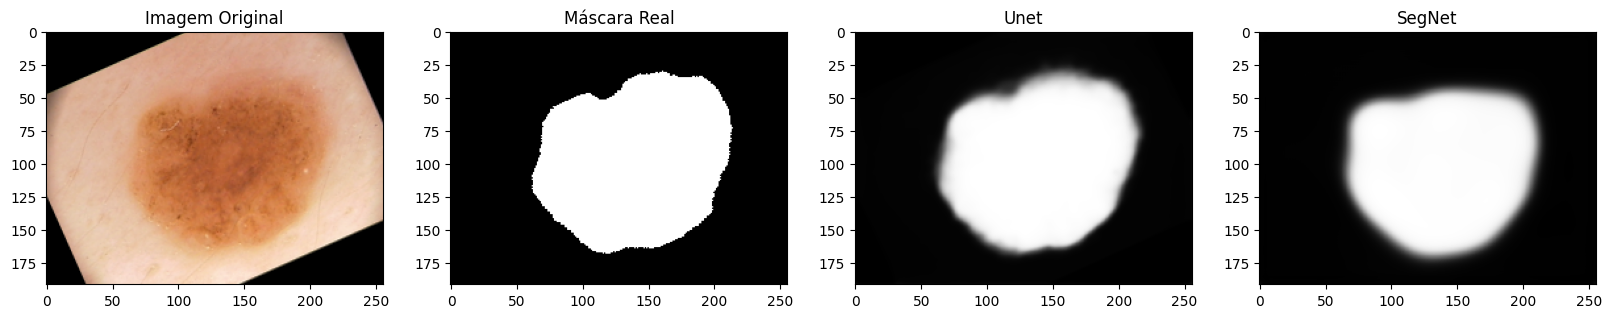

In [22]:
img_num = 108
img_pred1 = unet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
img_pred2 = segnet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test_full[img_num])
plt.title('Imagem Original')
plt.subplot(1,4,2)
plt.imshow(y_test_full[img_num], plt.cm.binary_r)
plt.title('Máscara Real')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet')
plt.show()

1/1 [==============================] - 0s 37ms/step


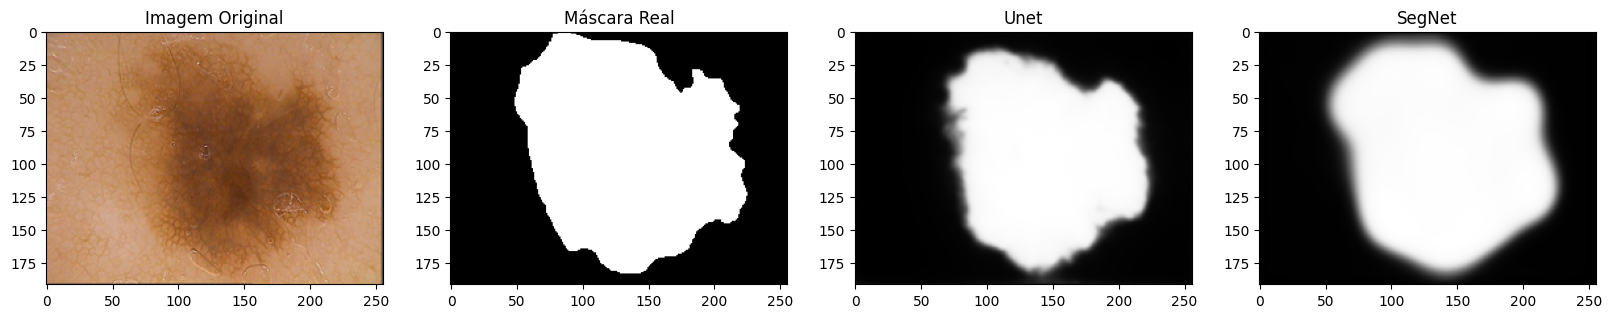

In [23]:
img_num = 205
img_pred1 = unet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
img_pred2 = segnet_model.predict(x_test_full[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(x_test_full[img_num])
plt.title('Imagem Original')
plt.subplot(1,4,2)
plt.imshow(y_test_full[img_num], plt.cm.binary_r)
plt.title('Máscara Real')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet')
plt.show()


- U-Net: melhor nas bordas
- SegNet: menos tuidos

In [24]:
print('\n-------------TREINO--------------------------\n')
res_unet = segnet_model.evaluate(x_train, y_train, batch_size= 8)
res_segnet = unet_model.evaluate(x_train, y_train, batch_size= 8)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')
print('\n-------------TESTE--------------------------\n')
res_unet = unet_model.evaluate(x_test_full, y_test_full, batch_size= 4)
res_segnet = segnet_model.evaluate(x_test_full, y_test_full, batch_size= 4)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')
print('\n-------------VALIDAÇÃO---------------------\n')
res_unet = unet_model.evaluate(x_val, y_val, batch_size= 4)
res_segnet = segnet_model.evaluate(x_val, y_val, batch_size= 4)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]*100, res_unet[0] * 100))
print('________________________')


-------------TREINO--------------------------

160/160 [==============================] - 13s 61ms/step - loss: 0.0405 - iou: 0.9595 - dice_coef: 0.8896 - precision: 0.9480 - recall: 0.9146 - accuracy: 0.9570
_______________SegNet_____Unet____
IOU:       |   95.95  |   96.74  |
Dice Coef: |   88.96  |   89.05  |
Precision: |   94.80  |   95.05  |
Recall:    |   91.46  |   94.53  |
Accuracy:  |   95.70  |   96.83  |
Loss:      |   4.05  |   9.38  |
________________________

-------------TESTE--------------------------

100/100 [==============================] - 9s 60ms/step - loss: 0.1046 - iou: 0.9657 - dice_coef: 0.8743 - precision: 0.9383 - recall: 0.9422 - accuracy: 0.9642
_______________SegNet_____Unet____
IOU:       |   96.57  |   95.54  |
Dice Coef: |   87.43  |   87.33  |
Precision: |   93.83  |   92.83  |
Recall:    |   94.22  |   92.17  |
Accuracy:  |   96.42  |   95.00  |
Loss:      |   10.46  |   4.46  |
________________________

-------------VALIDAÇÃO---------------------
